In [1]:
!pip install Sastrawi
!pip install swifter
!pip install deap

import pandas as pd
import numpy as np
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from sklearn import svm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=cbfcaab9050e56fee806f2138a7538aebcfc4960008838627969a8d65f0d2e75
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.4 MB/s eta 0:00:00


# import dataset

In [3]:
#menghubungkan ke gdrive
from google.colab import drive
drive.mount('/content/drive')
#memasukan dataset
from google.colab import drive
ulasan = pd.read_csv('dataset_ulasan_kredivoo.csv')
ulasan.head(10)

Mounted at /content/drive


,userName,score,at,content,sentimen
0,Dedi Juniyadi,1,2024-01-27 12:34:59,Baru kali ini saya bener bener di rugikaaan sa...,negatif
1,adam septialam,1,2024-02-06 11:34:08,"Akun premium yg ngga jelas, limit besar tp ngg...",negatif
2,CHRISTIAN YUYANTO,5,2024-03-28 08:10:00,Kredivo pelayanan dan pencairan cepat dan bung...,positif
3,Adrian Wildansyahlan,5,2024-03-27 04:34:35,Luar biasa kredivo,netral
4,memi eL,5,2024-03-09 10:10:54,Sampai saat ini aplikasi KREDIVO sangat memban...,positif
5,Cazorla Avisha hendrawan,1,2024-03-20 12:03:21,Saya ada transaksi pakai q rish..tagihan sudah...,positif
6,mas Ach,2,2024-03-28 06:31:27,"Sering make,baik buat belanja dan pinjaman ,ru...",negatif
7,Kriz Kriz,1,2024-03-05 01:22:12,"Saya merasa dirugikan oleh kredivo, mengajukan...",positif
8,Mahfud Sodiq,5,2024-03-18 09:06:24,"Mempermudah transaksi, proses super cepat, san...",positif
9,Boax Ortega,5,2024-03-29 04:34:39,Keren,netral


jumlah sentimen :
sentimen
positif    791
negatif    557
netral     406
Name: count, dtype: int64


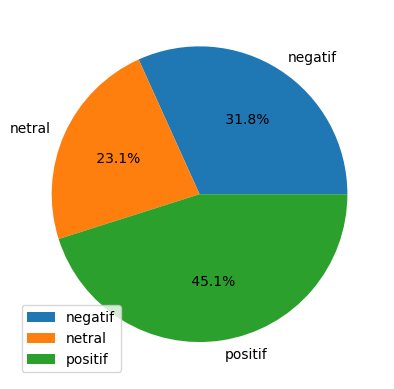

In [4]:
# melihat jumlah kelas sentimen
Jumlah_sentimen = ulasan['sentimen'].value_counts()
print("jumlah sentimen :")
print(Jumlah_sentimen)
# menampilkan dalam bentuk plot diagram
import matplotlib.pyplot as plt
%matplotlib inline
labels = ['negatif' , 'netral', 'positif']
plt.pie(ulasan.groupby('sentimen')['sentimen'].count(), autopct=" %.1f%% " ,labels=labels)
plt.legend()
plt.show()

# cleansing

In [5]:
def cleaningulasan(ulasan):

  ulasan = re.sub(r'#[A-Za-z0-9]+',' ',ulasan)
  ulasan = re.sub(r"http\S+",' ',ulasan)
  ulasan = re.sub(r'[0-9]+',' ',ulasan)
  ulasan = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", ulasan)
  #menghapus karakter tunggal
  ulasan = re.sub(r"\b[a-zA-Z]\b", " ", ulasan)
  ulasan = ulasan.strip(' ')
  return ulasan
ulasan['Cleaning']= ulasan['content'].apply(cleaningulasan)


def clearEmoji(ulasan):
    return ulasan.encode('ascii', 'ignore').decode('ascii')
ulasan['HapusEmoji']= ulasan['Cleaning'].apply(clearEmoji)

def replaceTOM(ulasan):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', ulasan)
ulasan['cleansing']= ulasan['HapusEmoji'].apply(replaceTOM)

ulasan[['content','cleansing']]
ulasan[['content','cleansing']].to_csv('cleansingb.csv', index=False,float_format='%.2f')

# case folding

In [6]:
def casefoldingText(ulasan):
  ulasan = ulasan.lower()
  return ulasan
ulasan['CaseFolding']= ulasan['cleansing'].apply(casefoldingText)
ulasan[['cleansing','CaseFolding']]
ulasan[['cleansing','CaseFolding']].to_csv('casefolding.csv', index=False)

# tokenizing

In [7]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def tokenizingText(ulasan):
  ulasan = word_tokenize(ulasan)
  return ulasan
ulasan['Tokenizing']= ulasan['CaseFolding'].apply(tokenizingText)
ulasan[['CaseFolding','Tokenizing']]
ulasan[['CaseFolding','Tokenizing']].to_csv('tokenizing.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# stemming

In [8]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(ulasan):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    # Lakukan stemming pada setiap kata
    stemmed_words = [stemmer.stem(word) for word in ulasan]
    return stemmed_words

ulasan['Stemming_list'] = ulasan['Tokenizing'].apply(stemming)

#merubah list ke str
ulasan['Stemming'] = ulasan['Stemming_list'].apply(' '.join)

#menampilkan data hasil stemming
ulasan[['Tokenizing','Stemming']]
ulasan[['Tokenizing','Stemming']].to_csv('stemming.csv', index=False)

# negasi handling

In [9]:
def handle_negation(ulasam):
    negation_words = ["tidak", "bukan", "tak", "tiada", "jangan", "gak"]
    new_words = []
    prev_word_is_negation = False
    for word in ulasam:
        if word in negation_words:
            new_words.append("tidak_")
            prev_word_is_negation = True
        elif prev_word_is_negation:
            new_words[-1] += word
            prev_word_is_negation = False
        else:
            new_words.append(word)
    return new_words
ulasan['negasi'] = ulasan['Stemming_list'].apply(handle_negation)
#menampilkan data hasil stemming
ulasan[['Stemming','negasi']]
ulasan[['Stemming','negasi']].to_csv('negasi.csv', index=False)

# word normalization

In [10]:
def convertToSlangword(ulasan):
    kamusSlang = eval(open("drive/MyDrive/SKRIPSI/kodingan/slangwords.txt").read())
    pattern = re.compile(r'\b( ' + '|'.join (kamusSlang.keys())+r')\b')
    content = []
    for kata in ulasan:
        filter_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata.lower())
        if filter_slang.startswith('tidak_'):
          kata_depan = 'tidak_'
          kata_belakang = kata[6:]
          kata_belakang_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata_belakang.lower())
          kata_hasil = kata_depan + kata_belakang_slang
          content.append(kata_hasil)
        else:
          content.append(filter_slang)
    ulasan = content
    return ulasan

ulasan['Formalisasi'] = ulasan['negasi'].apply(convertToSlangword)
ulasan[['negasi','Formalisasi']]
ulasan[['negasi','Formalisasi']].to_csv('word normalization.csv', index=False)

# stopword removal

In [11]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Mengunduh daftar stopword dari NLTK
daftar_stopword = stopwords.words('indonesian')

# Menambahkan stopword tambahan
daftar_stopword.extend(["yg", "dg", "rt", "dgn", "ny", "d",'gb','ahk','g'])

# Membaca file teks stopword menggunakan pandas
txt_stopword = pd.read_csv("drive/MyDrive/SKRIPSI/kodingan/stopwords.txt", names=["stopwords"], header=None)

# Menggabungkan daftar stopword dari NLTK dengan daftar stopword dari file teks
daftar_stopword.extend(txt_stopword['stopwords'].tolist())

# Mengubah daftar stopword menjadi set untuk pencarian yang lebih efisien
daftar_stopword = set(daftar_stopword)

def stopwordText(words):
    cleaned_words = []
    for word in words:
        # Memisahkan kata dengan tambahan "tidak_"
        if word.startswith("tidak_"):
            cleaned_words.append(word[:5])
            cleaned_words.append(word[6:])
        elif word not in daftar_stopword:
            cleaned_words.append(word)
    return cleaned_words

ulasan['Stopword_list'] = ulasan['Formalisasi'].apply(stopwordText)
#merubah list ke str
ulasan['Stopword Removal'] = ulasan['Stopword_list'].apply(' '.join)
ulasan[['Formalisasi','Stopword Removal']].to_csv('stopword.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
ulasan.to_csv('dataset_bersih.csv',index=False)

# pembobotan tf-idf

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = ulasan['Stopword Removal']
Y = ulasan['sentimen']

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.20)

vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)


# # Create CountVectorizer instance
# count_vectorizer = CountVectorizer()
# X_count = count_vectorizer.fit_transform(X)

# # Create TfidfTransformer instance
# tfidf_transformer = TfidfTransformer()
# X_tfidf = tfidf_transformer.fit_transform(X_count)

# # Create TfidfVectorizer instance
# tfidf_vectorizer = TfidfVectorizer()
# X_tfidf_vectorized = tfidf_vectorizer.fit_transform(X)

# # Get the feature names from CountVectorizer or TfidfVectorizer
# feature_names = count_vectorizer.get_feature_names_out()  # or tfidf_vectorizer.get_feature_names()

# # Create a dictionary to store the results
# results = {"Ulasan": [], "Term": [], "TF": [], "IDF": [], "TF-IDF": []}

# # Loop over the documents
# for i in range(len(X)):
#     # Add the document to the results dictionary
#     results["Ulasan"].extend([f" ulasan{i+1}"] * len(feature_names))
#     # Add the feature names to the results dictionary
#     results["Term"].extend(feature_names)
#     # Calculate the TF, IDF, and TF-IDF for each feature in the document
#     for j, feature in enumerate(feature_names):
#         tf = X_count[i, j]
#         idf = tfidf_transformer.idf_[j]  # or X_tfidf_vectorized.idf_[j]
#         tf_idf_score = X_tfidf[i, j]  # or X_tfidf_vectorized[i, j]
#         # Add the results to the dictionary
#         results["TF"].append(tf)
#         results["IDF"].append(idf)
#         results["TF-IDF"].append(tf_idf_score)
# # Convert the results dictionary to a Pandas dataframe
# df = pd.DataFrame(results)


# # Save the results to a CSV file
# df.to_csv("tf_idf_results.csv", index=False)

# #filter nilai term
# newdf = df[(df.TF != 0 )]
# newdf
# # Save the results to a CSV file
# newdf.to_csv("hasil TF IDF.csv", index=False)


## svm sebelum SMOTE

77.49287749287748
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        99
           1       0.97      0.60      0.74        93
           2       0.79      0.87      0.83       159

    accuracy                           0.77       351
   macro avg       0.80      0.75      0.76       351
weighted avg       0.80      0.77      0.77       351



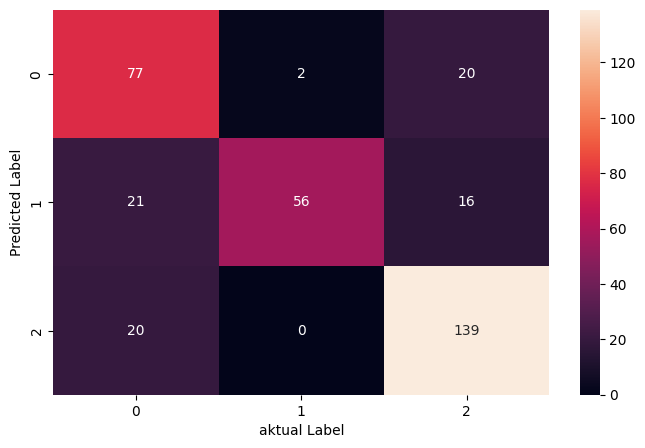

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
# Making the SVM Classifer
norm_svm_sebelum_smote = svm.SVC()

# Training the model on the training data and labels
norm_svm_sebelum_smote.fit(x_train, y_train)

# Using the model to predict the labels of the test data
y_pred = norm_svm_sebelum_smote.predict(x_test)

acc = accuracy_score(y_test,y_pred)*100
print(acc)
print(classification_report(y_test,y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel('aktual Label')
plt.ylabel('Predicted Label')
plt.show()

## deklarasi fungsi GA

In [15]:
###################################################################
### ENERGY EFFICIENCY DATASET (Y1 OUTPUT)
### SUPPORT VECTOR MACHINE
### FUNCTION DEFINITIONS
### OPTIMIZE HYPERPARAMETER C (CONTINUOUS)
### OPTIMIZE HYPERPARAMETER GAMMA (CONTINUOUS)
### DECODING / OBJ. VAL. / PARENT SELECTION / CROSSOVER / MUTATION
###################################################################
### Owner: Dana Bani-Hani
### Copyright © 2020 Curiosity for Data Science
###################################################################

import numpy as np
from sklearn.model_selection import KFold ,cross_val_score
from sklearn import svm

# menghitung nilai fitness untuk kromosom 0s dan 1s
def fitness(x,y,chromosome,kfold=5):

    # x = c
    lb_x = 1 # batas bawah kromosom x
    ub_x = 50 # batas atas kromosom x
    len_x = (len(chromosome)//2) # panjang kromosom x

    # y = gamma
    lb_y = 0.1 # batas bawah kromosom y
    ub_y = 1 # batas atas kromosom y
    len_y = (len(chromosome)//2) # panjang kromosom y

    precision_x = (ub_x-lb_x)/((2**len_x)-1) # presisi untuk decoding x
    precision_y = (ub_y-lb_y)/((2**len_y)-1) # presisi untuk decoding y

    z = 0 # karena kita mulai dari 2^0, dalam rumus
    t = 1 # karena kita mulai dari elemen terakhir vektor [indeks -1]
    x_bit_sum = 0 # inisiasi (sum(bit)*2^i adalah 0 pada awalnya)
    for i in range(len(chromosome)//2):
        x_bit = chromosome[-t]*(2**z)
        x_bit_sum = x_bit_sum + x_bit
        t = t+1
        z = z+1

    z = 0 # karena kita mulai dari 2^0, dalam rumus
    t = 1 + (len(chromosome)//2) # [6,8,3,9] (2 pertama adalah y, jadi indeksnya adalah 1+2 = -3)
    y_bit_sum = 0 # inisiasi (sum(bit)*2^i adalah 0 pada awalnya)
    for j in range(len(chromosome)//2):
        y_bit = chromosome[-t]*(2**z)
        y_bit_sum = y_bit_sum + y_bit
        t = t+1
        z = z+1

    # rumus untuk memecahkan kode kromosom 0s dan 1s menjadi bilangan aktual, nilai x atau y
    c_hyperparameter = (x_bit_sum*precision_x)+lb_x
    gamma_hyperparameter = (y_bit_sum*precision_y)+lb_y

    kf = KFold(n_splits=kfold)

    # objective function value for the decoded x and decoded y
    sum_of_error = 0
    for train_index,test_index in kf.split(x,y):
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]

        model = svm.SVC(kernel="rbf",
                        C=c_hyperparameter,
                        gamma=gamma_hyperparameter)
        model.fit(x_train,np.ravel(y_train))

        accuracy = model.score(x_test,y_test)
        error = 1-(accuracy)
        sum_of_error += error

    avg_error = sum_of_error/kfold

    # fungsi yang ditentukan akan mengembalikan 3 nilai
    return c_hyperparameter,gamma_hyperparameter,avg_error


# menemukan 2 parent dari kumpulan solusi
# menggunakan metode tournament selection
def find_parents_ts(all_solutions,x,y):

    # membuat array kosong untuk parent yang di pilih
    parents = np.empty((0,np.size(all_solutions,1)))

    for i in range(2): # melakukan proses untuk mendapatkan 2 parent

        # memilih 3 parent acak dari kumpulan solusi yang Anda miliki

        # mendapatkan 3 integer
        indices_list = np.random.choice(len(all_solutions),3,
                                        replace=False)

        # dapatkan 3 kemungkinan parent untuk selection
        posb_parent_1 = all_solutions[indices_list[0]]
        posb_parent_2 = all_solutions[indices_list[1]]
        posb_parent_3 = all_solutions[indices_list[2]]


        # dapatkan nilai fitness untuk setiap kemungkinan parent
        # index no.2 karena fungsi fitness memberikan nilai fitness pada index no.2
        obj_func_parent_1 = fitness(x=x,y=y,chromosome=posb_parent_1)[2] # kemungkianan parent 1
        obj_func_parent_2 = fitness(x=x,y=y,chromosome=posb_parent_2)[2] # kemungkianan parent 2
        obj_func_parent_3 = fitness(x=x,y=y,chromosome=posb_parent_3)[2] # kemungkianan parent 3


        # mencari parent mana yang terbaik
        min_obj_func = min(obj_func_parent_1,obj_func_parent_2,
                           obj_func_parent_3)

        if min_obj_func == obj_func_parent_1:
            selected_parent = posb_parent_1
        elif min_obj_func == obj_func_parent_2:
            selected_parent = posb_parent_2
        else:
            selected_parent = posb_parent_3

        # letakkan parent yang dipilih dalam array kosong yang kami buat di atas
        parents = np.vstack((parents,selected_parent))

    parent_1 = parents[0,:] # parent_1, elemen pertama di dalam array
    parent_2 = parents[1,:] # parent_2, elemen kedua di dalam array

    return parent_1,parent_2 # fungsi akan mengembalikan 2 nilai array



# crossover antara  2 parents untuk membuat 2 children
# input functions adalah parent_1, parent_2, dan  probability dari crossover
# default probability dari crossover adalah 1
def crossover(parent_1,parent_2,prob_crsvr=0.6):

    child_1 = np.empty((0,len(parent_1)))
    child_2 = np.empty((0,len(parent_2)))


    rand_num_to_crsvr_or_not = np.random.rand() # apakah kita melakukan crossover atau tidak???

    if rand_num_to_crsvr_or_not < prob_crsvr:
        index_1 = np.random.randint(0,len(parent_1))
        index_2 = np.random.randint(0,len(parent_1))

        # mendapatkan indices yang berbeda untuk memastikan Anda menyilangkan setidaknya satu gen

        while index_1 == index_2:
            index_2 = np.random.randint(0,len(parent_1))

        index_parent_1 = min(index_1,index_2)
        index_parent_2 = max(index_1,index_2)


        ### untuk PARENT_1 ###

        # first_seg_parent_1 -->
        # untuk parent_1: genes yang bermula dari awal parent_1 ke pertengahan segmen parent_1

        first_seg_parent_1 = parent_1[:index_parent_1]

        # middle segment; letak crossover terjadi
        # for parent_1: genes dari index yang di pilih untuk parent_1 ke index yang di pilih dari parent_1

        mid_seg_parent_1 = parent_1[index_parent_1:index_parent_2+1]

        # last_seg_parent_1 -->
        # for parent_1: genes dari ujung segmen tengah dari parent_1 ke akhir genes dari parent_1

        last_seg_parent_1 = parent_1[index_parent_2+1:]


        ### FOR PARENT_2 ###

        # first_seg_parent_2 --> sama seperti parent_1
        first_seg_parent_2 = parent_2[:index_parent_1]

        # mid_seg_parent_2 --> sama seperti parent_1
        mid_seg_parent_2 = parent_2[index_parent_1:index_parent_2+1]

        # last_seg_parent_2 --> sama seperti parent_1
        last_seg_parent_2 = parent_2[index_parent_2+1:]


        ### membuat CHILD_1 ###

        # segmen pertama dari parent_1
        # ditambah segmen tengah dari parent_2
        # di tambah segmen akhir dari parent_1
        child_1 = np.concatenate((first_seg_parent_1,mid_seg_parent_2,
                                  last_seg_parent_1))


        ### membuat CHILD_2 ###

        # segmen pertama dari parent_2
        # ditambah segmen tengah dari parent_1
        # di tambah segmen akhir dari parent_2
        child_2 = np.concatenate((first_seg_parent_2,mid_seg_parent_1,
                                  last_seg_parent_2))


    # syarat ketika kita tidak mau melakukan crossover
    # ketika rand_num_to_crsvr_or_not tidak kurang atau lebih besar dari prob_crsvr
    # akan tetapi ketika prob_crsvr == 1, lalu rand_num_to_crsvr_or_not akan selalu kurang dari prob_crsvr, jadi akan selalu di lakukan crossover

    else:
        child_1 = parent_1
        child_2 = parent_2

    return child_1,child_2 # fungsi akan mengembalikan 2 array



############################################################
### MUTATING 2 CHILDREN untuk membuat MUTATED CHILDREN ###
############################################################

# mutation dari 2 children
# input functions adalah child_1, child_2, dan probability dari mutation
# default probability dari mutation is 0.2
def mutation(child_1,child_2,prob_mutation=0.2):

    # mutated_child_1
    mutated_child_1 = np.empty((0,len(child_1)))

    t = 0 # mulai dari indeks paling pertama child_1
    for i in child_1: # untuk setiap gene (index)

        rand_num_to_mutate_or_not = np.random.rand() # apakah kita bermutasi atau tidak???

        # jika rand_num_to_mutate_or_not kurang dari kemungkinan mutasi
        # lalu kita bermutasi pada gen yang diberikan itu (indeks tempat kita berada saat ini)
        if rand_num_to_mutate_or_not < prob_mutation:

            if child_1[t] == 0: # jika kita mutate, a 0 menjadi a 1
                child_1[t] = 1

            else:
                child_1[t] = 0  # jika kita mutate, a 1 menjadi a 0

            mutated_child_1 = child_1

            t = t+1

        else:
            mutated_child_1 = child_1

            t = t+1


    # mutated_child_2
    # proses yang sama pada mutated_child_1
    mutated_child_2 = np.empty((0,len(child_2)))

    t = 0
    for i in child_2:

        rand_num_to_mutate_or_not = np.random.rand() # probability dari mutate

        if rand_num_to_mutate_or_not < prob_mutation:

            if child_2[t] == 0:
                child_2[t] = 1

            else:
                child_2[t] = 0

            mutated_child_2 = child_2

            t = t+1

        else:
            mutated_child_2 = child_2

            t = t+1

    return mutated_child_1,mutated_child_2 # fungsi akan mengembalikan 2 arrays

## penerapan GA

In [16]:
import numpy as np
import pandas as pd
import random as rd
#import time
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import svm
# import SVM_HParam_Opt_Functions as svm_hp_opt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt

x =x_train

y =y_train

# hyperparameters (user inputted parameters)
prob_crsvr = 0.6 # probablity of crossover
prob_mutation = 0.2 # probablity of mutation
population =40 # population number
generations = 20 # generation number

kfold = 5

# x and y decision variables' encoding
# 12 genes for x and 12 genes for y (arbitrary number)
x_y_string = np.array([0,1,0,0,0,1,0,0,1,0,0,1,
                       0,1,1,1,0,0,1,0,1,1,1,0]) # initial solution

# create an empty array to put initial population
pool_of_solutions = np.empty((0,len(x_y_string)))

# create an empty array to store a solution from each generation
# for each generation, we want to save the best solution in that generation
# to compare with the convergence of the algorithm
best_of_a_generation = np.empty((0,len(x_y_string)+1))

# shuffle the elements in the initial solution (vector)
# shuffle n times, where n is the no. of the desired population
for i in range(population):
    rd.shuffle(x_y_string)
    pool_of_solutions = np.vstack((pool_of_solutions,x_y_string))


# so now, pool_of_solutions, has n (population) chromosomes


#start_time = time.time() # start time (timing purposes)

gen = 1 # we start at generation no.1 (tracking purposes)
# Membuat list untuk menyimpan hasil
gene=[]
c_values = []
gamma_values = []
fitness_values = []
cb_values = []
gammab_values = []
fitnessb_values = []

for i in range(generations): # do it n (generation) times

    # an empty array for saving the new generation
    # at the beginning of each generation, the array should be empty
    # so that you put all the solutions created in a certain generation
    new_population = np.empty((0,len(x_y_string)))

    # an empty array for saving the new generation plus its fitness
    new_population_with_fitness_val = np.empty((0,len(x_y_string)+1))

    # an empty array for saving the best solution (chromosome)
    # for each generation
    sorted_best = np.empty((0,len(x_y_string)+1))

    print()
    print()
    print("--> Generation: #", gen) # tracking purposes


    family = 1 # we start at family no.1 (tracking purposes)


    for j in range(int(population/2)): # population/2 because each gives 2 parents

        print()
        print("--> Family: #", family) # tracking purposes


        # selecting 2 parents using tournament selection
        # "genf.find_parents_ts"[0] gives parent_1
        # "genf.find_parents_ts"[1] gives parent_2
        parent_1 = find_parents_ts(pool_of_solutions,x=x,y=y)[0]
        parent_2 = find_parents_ts(pool_of_solutions,x=x,y=y)[1]


        # crossover the 2 parents to get 2 children
        # "genf.crossover"[0] gives child_1
        # "genf.crossover"[1] gives child_2
        child_1 = crossover(parent_1,parent_2,prob_crsvr=prob_crsvr)[0]
        child_2 = crossover(parent_1,parent_2,prob_crsvr=prob_crsvr)[1]


        # mutating the 2 children to get 2 mutated children
        # "genf.mutation"[0] gives mutated_child_1
        # "genf.mutation"[1] gives mutated_child_2
        mutated_child_1 = mutation(child_1,child_2, prob_mutation=prob_mutation)[0]
        mutated_child_2 = mutation(child_1,child_2,prob_mutation=prob_mutation)[1]


        # getting the obj val (fitness value) for the 2 mutated children
        # "genf.objective_value"[2] gives obj val for the mutated child
        fitness_val_mutated_child_1 = fitness(x=x,y=y,chromosome=mutated_child_1,kfold=kfold)[2]
        fitness_val_mutated_child_2 = fitness(x=x,y=y,chromosome=mutated_child_2,kfold=kfold)[2]


        # for each mutated child, put its obj val next to it
        mutant_1_with_fitness_val = np.hstack((fitness_val_mutated_child_1,
                                               mutated_child_1)) # lines 132 and 140

        mutant_2_with_fitness_val = np.hstack((fitness_val_mutated_child_2,
                                               mutated_child_2)) # lines 134 and 143


        # we need to create the new population for the next generation
        # so for each family, we get 2 solutions
        # we keep on adding them till we are done with all the families in one generation
        # by thes end of each generation, we should have the same number as the initial population
        # so this keeps on growing and growing
        # when it's a new generation, this array empties and we start the stacking process
        # and so on
        # check line 88
        new_population = np.vstack((new_population,
                                    mutated_child_1,
                                    mutated_child_2))


        # same explanation as above, but we include the obj val for each solution as well
        # check line 91
        new_population_with_fitness_val = np.vstack((new_population_with_fitness_val,
                                                 mutant_1_with_fitness_val,
                                                 mutant_2_with_fitness_val))
        print(f"Parent 1: {parent_1}")
        print(f"Parent 2: {parent_2}")
        print(f"Child 1: {child_1}")
        print(f"Child 2: {child_2}")
        print(f"Mutated Child 1: {mutated_child_1}")
        print(f"Mutated Child 2: {mutated_child_2}")
        print(f"fitness error val Mutated Child 1: {fitness_val_mutated_child_1}")
        print(f"fitness error val Mutated Child 2: {fitness_val_mutated_child_2}")


        # after getting 2 mutated children (solutions), we get another 2, and so on
        # until we have the same number of the intended population
        # then we go to the next generation and start over
        # since we ended up with 2 solutions, we move on to the next possible solutions
        family = family+1


    # check line 60
    # check line 164
    # we replace the initial (before) population with the new one (current generation)
    # this new pool of solutions becomes the starting population of the next generation
    pool_of_solutions = new_population


    # for each generation
    # we want to find the best solution in that generation
    # so we sort them based on index [0], which is the obj val
    sorted_best = np.array(sorted(new_population_with_fitness_val,
                                               key=lambda x:x[0]))


    # since we sorted them from best to worst
    # the best in that generation would be the first solution in the array
    # so index [0] of the "sorted_best" array
    best_of_a_generation = np.vstack((best_of_a_generation,
                                      sorted_best[0]))


    sorted_best_of_a_generation = np.array(sorted(best_of_a_generation,
                                         key=lambda x:x[0]))
    # increase the counter of generations (tracking purposes)
    gen = gen+1


    best_string_convergence = sorted_best[0]
    best_string_bestvalue = sorted_best_of_a_generation[0]
    final_solution_convergence = fitness(x=x,y=y,chromosome=best_string_convergence[0:],kfold=kfold)
    final_solution_best = fitness(x=x,y=y,chromosome=best_string_bestvalue[0:],kfold=kfold)

    # menyimpan nilai C, gamma, dan fitness
    gene.append(gen-1)

    c_values.append(final_solution_convergence[0])
    gamma_values.append(final_solution_convergence[1])
    fitness_values.append(final_solution_convergence[2])

    cb_values.append(final_solution_best[0])
    gammab_values.append(final_solution_best[1])
    fitnessb_values.append(final_solution_best[2])

    # create a dictionary to store the data
    results = {'generasi':gene,
               'C_con': c_values,
               'Gamma_con': gamma_values,
               'Fitness_con': fitness_values,
               'C_best': cb_values,
               'Gamma_best': gammab_values,
               'Fitness_best': fitnessb_values}

    print("Generation:", i+1)
    print("C convergen:", c_values)
    print("Gamma convergen:", gamma_values)
    print("Fitness avg error convergen:", fitness_values)
    print("C best:", cb_values)
    print("Gamma best:", gammab_values)
    print("Fitness avg error best:", fitnessb_values)

result=pd.DataFrame(results)
# save the dataframe to a CSV file
result.to_csv('GA_result.csv', index=False)


# check line 171
# for our very last generation, we have the last population
# for this array of last population (convergence), there is a best solution
# so we sort them from best to worst
sorted_last_population = np.array(sorted(new_population_with_fitness_val,
                                         key=lambda x:x[0]))

sorted_best_of_a_generation = np.array(sorted(best_of_a_generation,
                                         key=lambda x:x[0]))

sorted_last_population[:,0] = (sorted_last_population[:,0]) # get accuracy instead of error
sorted_best_of_a_generation[:,0] = (sorted_best_of_a_generation[:,0])

# since we sorted them from best to worst
# the best would be the first solution in the array
# so index [0] of the "sorted_last_population" array
best_string_convergence = sorted_last_population[0]

best_string_overall = sorted_best_of_a_generation[0]

print()
#print()
#print("Execution Time in Minutes:",(end_time - start_time)/60) # exec. time

print()
print()
print("------------------------------")
print()

#print("Execution Time in Seconds:",end_time - start_time) # exec. time
#print()

print("Final Solution (Convergence):",best_string_convergence[1:]) # final solution entire chromosome
print("Encoded C (Convergence):",best_string_convergence[1:14]) # final solution x chromosome
print("Encoded Gamma (Convergence):",best_string_convergence[14:]) # final solution y chromosome
print()
print("Final Solution (Best):",best_string_overall[1:]) # final solution entire chromosome
print("Encoded C (Best):",best_string_overall[1:14]) # final solution x chromosome
print("Encoded Gamma (Best):",best_string_overall[14:]) # final solution y chromosome

# to decode the x and y chromosomes to their real values
final_solution_convergence = fitness(x=x,y=y,chromosome=best_string_convergence[1:],kfold=kfold)

final_solution_overall = fitness(x=x,y=y,chromosome=best_string_overall[1:],kfold=kfold)

# the "svm_hp_opt.objective_value" function returns 3 things -->
# [0] is the x value
# [1] is the y value
# [2] is the obj val for the chromosome (avg. error)
print()
print("Decoded C (Convergence):",round(final_solution_convergence[0],5)) # real value of x
print("Decoded Gamma (Convergence):",round(final_solution_convergence[1],5)) # real value of y
print("Obj Value - Convergence:",round((final_solution_convergence[2]),5)) # obj val of final chromosome
print()
print("Decoded C (Best):",round(final_solution_overall[0],5)) # real value of x
print("Decoded Gamma (Best):",round(final_solution_overall[1],5)) # real value of y
print("Obj Value - Best in Generations:",round((final_solution_overall[2]),5)) # obj val of final chromosome
print()
print("------------------------------")
import pandas as pd

# Simpan hasil objek value terbaik dari setiap generasi dalam sebuah DataFrame
df_generations = pd.DataFrame(best_of_a_generation, columns=['obj_val'] + ['gen_' + str(i) for i in range(len(x_y_string))])

# Simpan hasil parameter terbaik
df_best = pd.DataFrame({'parameter': ['C', 'gamma'],
                        'convergence': [final_solution_convergence[0], final_solution_convergence[1]],
                        'best_in_generations': [final_solution_overall[0], final_solution_overall[1]]})

# Simpan hasil generasi, parameter, dan objek value ke dalam file CSV
df_generations.to_csv('hasil_generasi.csv', index=False)
df_best.to_csv('hasil_parameter.csv', index=False)

print("c :",final_solution_overall[0])
print("gamma :",final_solution_overall[1])

# Create SVM model
svm = svm.SVC(kernel='rbf', C=final_solution_overall[0],gamma=final_solution_overall[1])

# Perform k-fold cross validation
scores = cross_val_score(svm, x, y, cv=5)
print('akurasi sklearn :',scores)
print('rata-rata akurasi sklearn:', scores.mean())





--> Generation: # 1

--> Family: # 1
Parent 1: [1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
Parent 2: [0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0.]
Child 1: [0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
Child 2: [1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
Mutated Child 1: [0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
Mutated Child 2: [1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
fitness error val Mutated Child 1: 0.22593797661413317
fitness error val Mutated Child 2: 0.2202389425521098

--> Family: # 2
Parent 1: [1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Parent 2: [1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.]
Child 1: [1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Child 2: [1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0

## penerapan GA-SVM

78.63247863247864
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        99
           1       0.93      0.70      0.80        93
           2       0.79      0.87      0.83       159

    accuracy                           0.79       351
   macro avg       0.80      0.77      0.78       351
weighted avg       0.80      0.79      0.79       351



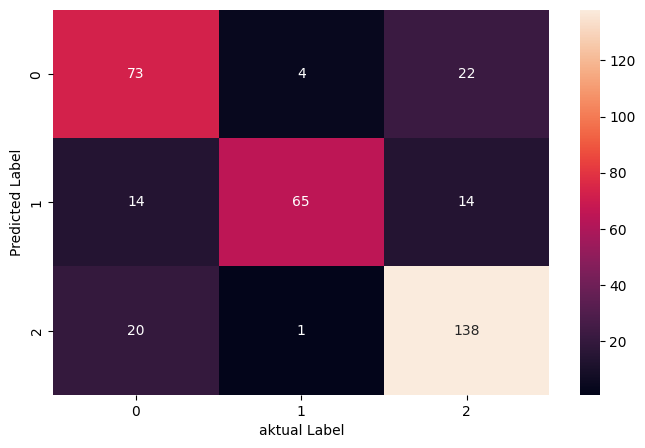

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import svm
# Making the SVM Classifer
GA_SVM_sebelum_smote = svm.SVC(kernel='rbf', C=final_solution_overall[0],gamma=final_solution_overall[1])

# Training the model on the training data and labels
GA_SVM_sebelum_smote.fit(x_train, y_train)

# Using the model to predict the labels of the test data
y_pred = GA_SVM_sebelum_smote.predict(x_test)

acc = accuracy_score(y_test,y_pred)*100
print(acc)
print(classification_report(y_test,y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel('aktual Label')
plt.ylabel('Predicted Label')
plt.show()